In [1]:
from scipy.sparse.linalg import splu, factorized
from scipy.linalg import lu_factor, lu_solve
import numpy as np
np.set_printoptions(precision=4) # Print few decimal places
np.set_printoptions(suppress=True) # Suppress scientific notation
import cvxpy as cp
import pandas as pd
from numpy.linalg import cholesky as llt
import matplotlib.pyplot as plt
import scipy.stats as stats
import time

Generating Data Function

In [2]:
def generate_randn_data(m,n):
    w = np.random.randn(n)
    # w = np.random.normal(0, 100, n)
    x = np.maximum(w, 0)
    lambd = np.maximum(-w, 0)
    A = np.random.randn(m,n)
    # A = np.random.normal(0, 500, (m,n))
    nu = np.random.randn(m)
    b = A @ x
    
    c = - A.T @ nu + lambd
    return A, b, c, x, lambd, nu

Testing CVXPY and Formulation

In [3]:
np.random.seed(142)
# NOTE
# Test case and the formulation for the splitting
n = 10
m = 10
A_, b_, c_, x_, lambd_, nu_ = generate_randn_data(m, n)
u = np.random.uniform(np.max(x_), 5*np.max(x_), n) 
l = -u

# NOTE
# TESTING

# u_ = np.copy(u)
# l_ = np.copy(l)
# indices_u = np.random.choice(n, size=int(10/2), replace=False)
# indices_l = np.random.choice(n, size=int(10/2), replace=False)
# for i in indices_u:
#     u_[i] = x_[i]
# for i in indices_l:
#     l_[i] = x_[i]

# x_cvxpy = cp.Variable(x_.shape)
# objective = cp.Minimize(c_.T @ x_cvxpy)
# constraints = [A_ @ x_cvxpy == b_, x_cvxpy >= l_, x_cvxpy <= u_]
# problem = cp.Problem(objective, constraints)
# problem.solve()
# print(problem.status)
# print("cvxpy value =", c_.T @ x_cvxpy.value)
# print("actual value =", c_.T @ x_)
# print(u_ - x_cvxpy.value)
# print(x_cvxpy.value - l_)



x_cvxpy = cp.Variable(x_.shape)
objective = cp.Minimize(c_.T @ x_cvxpy)
constraints = [A_ @ x_cvxpy == b_, x_cvxpy >= l, x_cvxpy <= u]
problem = cp.Problem(objective, constraints)
problem.solve()
print(problem.status)
print("cvxpy value =", c_.T @ x_cvxpy.value)
print("actual value =", c_.T @ x_)


x_cvxpy_u = cp.Variable(int(0.5*n))
x_cvxpy_l = cp.Variable(n-int(0.5*n))
objective = cp.Minimize(c_[:int(0.5*n)].T@x_cvxpy_u + c_[int(0.5*n):].T@x_cvxpy_l)
constraints = [A_[:,:int(0.5*n)]@x_cvxpy_u + A_[:,int(0.5*n):]@x_cvxpy_l == b_,
               x_cvxpy_u >= l[:int(0.5*n)], x_cvxpy_l >= l[int(0.5*n):],
               x_cvxpy_u <= u[:int(0.5*n)], x_cvxpy_l <= u[int(0.5*n):]]
problem = cp.Problem(objective, constraints)
problem.solve()
print(problem.status)
print("cvxpy value =", c_[:int(0.5*n)].T@x_cvxpy_u.value + c_[int(0.5*n):].T@x_cvxpy_l.value)
print("actual value =", c_.T @ x_)


optimal
cvxpy value = 7.5518269074962
actual value = 7.5518269074962
optimal
cvxpy value = 7.5518269074962
actual value = 7.5518269074962


Utility Functions

In [4]:
# NOTE
# I implemented a rudementary version for simplicity and to first make sure that this worked

def ADMM(c1, c2, U, V, q, u, l, xu, xv, y, nu):
    var1 = cp.Variable(xu.shape[0])
    constraint1 = [var1 <= u[:xu.shape[0]], l[:xu.shape[0]] <= var1]
    prob_1 = cp.Problem(cp.Minimize(c1 @ var1 + (nu/2) * cp.sum_squares((U @ var1 + V @ xv - q) - (1/nu) * y)), constraint1)
    prob_1 = cp.Problem(cp.Minimize(c1 @ var1 + (nu/2) * cp.sum_squares((U @ var1 + V @ xv - q) + y)), constraint1)
    prob_1.solve()
    
    xu_next = var1.value
    
    var_2 = cp.Variable(xv.shape[0])
    constraint2 = [var_2 <= u[xv.shape[0]:], l[xv.shape[0]:] <= var_2]
    prob_2 = cp.Problem(cp.Minimize(c2 @ xv + (nu/2) * cp.sum_squares((U @ xu_next + V @ var_2 - q) - (1/nu) * y)), constraint2)
    prob_2 = cp.Problem(cp.Minimize(c2 @ xv + (nu/2) * cp.sum_squares((U @ xu_next + V @ var_2 - q) + y)), constraint2)
    prob_2.solve()
    
    xv_next = var_2.value
    
    y_next = y - nu * (U @ xu_next + V @ xv_next - q)
    y_next = y + U @ xu_next + V @ xv_next - q
    z_hat_next = [xu_next, xv_next, y - nu * (U @ xu_next + V @ xv - q)]
    z_next = [xu_next, xv_next, y_next]
    
    return z_hat_next, z_next


def KKT_error(nu, A, b, K, c, lam, lam_plus, lam_minus, q, l, u, x, y, U, V, z, z_prev):
    
    norm1 = np.linalg.norm(A@x - b, 2) ** 2
    
    # Normal dual residual
    norm2 = np.linalg.norm(c - K.T @ y - lam, 2) ** 2
    # ADMM dual residual
    norm2 = np.linalg.norm(nu*U.T@V@(z - z_prev), 2) ** 2
    
    KKT = np.sqrt(nu**2 * norm1 + (1/(nu**2)) * norm2 + (q.T@y + l.T@lam_plus - u.T@lam_minus - c.T@x) ** 2)
    
    return KKT


def lam_comp(A, y, xu, xv, u, l, c):
    lam_pos = np.ones(xu.shape[0] + xv.shape[0])
    lam_neg = np.ones(xu.shape[0] + xv.shape[0])
    
    for i in range(xu.shape[0]):
        if not abs(xu[i] - l[i]) <= 1e-5:
            lam_pos[i] = 0
        if not abs(xu[i] - u[i]) <= 1e-5:
            lam_neg[i] = 0

    for i in range(xu.shape[0], lam_pos.shape[0]):
        if not abs(xv[i-xu.shape[0]] - l[i]) <= 1e-5:
            lam_pos[i] = 0
        if not abs(xv[i-xu.shape[0]] - u[i]) <= 1e-5:
            lam_neg[i] = 0
            
    for i in range(A.T.shape[0]):
        if lam_pos[i] != 0:
            # lam_pos[i] = -(A.T @ y)[i]
            # lam_pos[i] = (c[i]-(A.T @ y)[i]) / l[i]
            lam_pos[i] = (c-(A.T @ y))[i] / l[i]
        elif lam_neg[i] != 0:
            # lam_neg[i] = (A.T @ y)[i] 
            # lam_neg[i] = ((A.T @ y)[i] - c[i]) / u[i]
            lam_neg[i] = ((A.T @ y) - c)[i] / u[i]

    lam = np.vstack([lam_pos, lam_neg])
    
    return lam

ADMM + KKT Restarts

In [5]:
# NOTE
# ADMM + Restarts

np.random.seed(142)

n = 100
m = 5 * n
A, b, c, x_, lambd, nu = generate_randn_data(m, n)
u = np.random.uniform(np.max(x_), 5*np.max(x_), n) 
l = -u

# Total iterations Number
iterations = 200

c1 = c[:int(0.5*n)]
c2 = c[int(0.5*n):]
U = A[:,:int(0.5*n)]
V = A[:,int(0.5*n):]
q = b
xu = np.zeros(int(0.5*n))
xv = np.zeros(n - int(0.5*n))
y = np.zeros(A.shape[0])
# NOTE Not sure if nu is the right value, just choose an argibrary one
nu = 0.3

z = np.zeros(500, dtype=object)
z_bar = 0

value_ADMM_restarts = []
KKT_valus_rest = []
duality_gap_res = []
primal_residual_rest = []
dual_residual_rest = []

# These are used for computation for KKT and lambda
K = np.hstack([U, V])
A = np.hstack([U, V])
x = np.hstack([xu, xv])
c = np.hstack([c1, c2])

# Computing the initial lambdas
lam = lam_comp(A, y, xu, xv, u, l, c)
lam_plus = lam[0]
lam_minus = lam[1]


# Implementing CVXPY to get the optimal values
x_cvxpy_u = cp.Variable(int(0.5*n))
x_cvxpy_l = cp.Variable(n-int(0.5*n))
objective = cp.Minimize(c1.T@x_cvxpy_u + c2.T@x_cvxpy_l)
constraints = [U@x_cvxpy_u + V@x_cvxpy_l == b,
               x_cvxpy_u >= l[:int(0.5*n)], x_cvxpy_l >= l[int(0.5*n):],
               x_cvxpy_u <= u[:int(0.5*n)], x_cvxpy_l <= u[int(0.5*n):]]
problem = cp.Problem(objective, constraints)
problem.solve()
print("Did cvxpy converge =", problem.status)
print("cvxpy value =", c1.T@x_cvxpy_u.value + c2.T@x_cvxpy_l.value)
print("actual value =", c.T @ x_)



# Initializing starter KKT values
KKT_prev = np.zeros(20, dtype=object)

KKT = KKT_error(nu, A, q, K, c, lam, lam_plus, lam_minus, q, l, u, x, nu*y, U, V, np.zeros(n - int(0.5*n)), np.zeros(n - int(0.5*n)))
KKT_prev[0] = -np.inf
KKT_prev[1] = -np.inf
KKT_n = -np.inf


# Beginning the iterations. I have here both the KKT restarts and the fixed interval restarts. The fixed interval restarts are commented out. In later versions I will 
# seperate the two and make them two seperate instances, here for simplicity they are put together
for f in range(1,2):
    # Initialize values
    count = 0
    xu = np.zeros(int(0.5*n))
    xv = np.zeros(n - int(0.5*n))
    y = np.zeros(A.shape[0])
    
    # Outer loop
    for i in range(200):
        # Reset values
        z[i] = z_bar
        
        xu_bar = 0
        xv_bar = 0
        y_bar = 0
        
        t = 0
        
        # Inner loop
        while not ((KKT <= 0.8 * KKT_n and KKT > KKT_prev[0]) or (KKT <= 0.2 * KKT_n) or (t >= max(0.36 * count,1))):
        # for g in range(f):
            # xv_prev used for KKT
            xv_prev = xv
            
            # ADMM
            z_hat, z_admm = ADMM(c1, c2, U, V, q, u, l, xu, xv, y, nu)

            # dual_residual_rest.append(np.linalg.norm(nu * U.T@V@(z_admm[1] - xv_prev),2)**2)
            
            xu = z_admm[0]
            xv = z_admm[1]
            y = z_admm[2]

            value_ADMM_restarts.append(abs(c1.T @ xu + c2.T @ xv - problem.value))
            diff = abs(c1.T @ xu + c2.T @ xv - problem.value)
            
            xu_bar = (t/(1+t)) * xu_bar + (1/(1+t)) * z_hat[0]
            xv_bar = (t/(1+t)) * xv_bar + (1/(1+t)) * z_hat[1]
            y_bar = (t/(1+t)) * y_bar + (1/(1+t)) * z_hat[2]
            
            K = np.hstack([U, V])
            A = np.hstack([U, V])
            x = np.hstack([xu, xv])
            c = np.hstack([c1, c2])
            
            lam = lam_comp(A, y, xu, xv, u, l, c)
            lam_plus = lam[0]
            lam_minus = lam[1]
            lam_KKT = lam_plus - lam_minus
            
            KKT = KKT_error(nu, A, q, K, c, lam_KKT, lam_plus, lam_minus, q, l, u, x, nu*y, U, V, xv, xv_prev)
            KKT_valus_rest.append(KKT)
            
            # Normal Duality Gap
            duality_gap_res.append((q.T@y + l.T@lam_plus - u.T@lam_minus - c.T@x))
            
            # Normalized Duality Gap
            # duality_gap_res.append(np.sqrt((q.T@y + l.T@lam_plus - u.T@lam_minus - c.T@x)**2)/np.sqrt((c.T@x)**2))
            
            primal_residual_rest.append(np.linalg.norm(A@x - b)**2)
            
            # Normal Dual Residual
            # dual_residual_rest.append(np.linalg.norm(c - K.T @ y - lam, 2) ** 2)
            
            # ADMM Dual Residual
            dual_residual_rest.append(np.linalg.norm(nu * U.T@V@(z_admm[1] - xv_prev),2)**2)
            
            
            KKT_prev[0] = KKT_prev[1]
            KKT_prev[1] = KKT
            
            # Update count
            t += 1
            count += 1
            
            if count >= iterations:
                break
            
            # if (value_ADMM_restarts[count] <= 1e-13):
            # if (diff <= 1e-10):
            #     # print("stoped iterations at index =", i)
            #     break
        # if value_ADMM_restarts[count] <= 1e-13:
        # if diff <= 1e-10:
        #     print("stoped iterations at index =", i)
        #     print("count =", count)
        #     print("f =", f)
        #     break
        if count >= iterations:
            print("For f =", f, "we go over 100 iterations")
            break
        
        # Outer Loop update
        KKT_n = KKT
        xu = xu_bar
        xv = xv_bar
        y = y_bar
        z_bar = [xu, xv, y]

print("count =", count)
print("ADMM with restarts value =", c1.T @ xu + c2.T @ xv)

Did cvxpy converge = optimal
cvxpy value = -305.46254458881356
actual value = -305.4625445888135
For f = 1 we go over 100 iterations
count = 200
ADMM with restarts value = -305.4625445888135


ADMM

In [6]:
# NOTE
# ADMM

np.random.seed(142)

KKT_valus = []
duality_gap = []
primal_residual = []
dual_residual = []

n = 100
m = 5 * n
A, b, c, x, lambd, nu = generate_randn_data(m, n)
u = np.random.uniform(np.max(x), 5*np.max(x), n) 
l = -u

iterations = 200


c1 = c[:int(0.5*n)]
c2 = c[int(0.5*n):]
U = A[:,:int(0.5*n)]
V = A[:,int(0.5*n):]
q = b
xu = np.zeros(int(0.5*n))
xv = np.zeros(n - int(0.5*n))
y = np.zeros(A.shape[0])
# NOTE Not sure if nu is the right value, just choose an argibrary one
nu = 0.3

# Implementing CVXPY to get the optimal values
x_cvxpy_u = cp.Variable(int(0.5*n))
x_cvxpy_l = cp.Variable(n-int(0.5*n))
objective = cp.Minimize(c1.T@x_cvxpy_u + c2.T@x_cvxpy_l)
constraints = [U@x_cvxpy_u + V@x_cvxpy_l == b,
               x_cvxpy_u >= l[:int(0.5*n)], x_cvxpy_l >= l[int(0.5*n):],
               x_cvxpy_u <= u[:int(0.5*n)], x_cvxpy_l <= u[int(0.5*n):]]
problem = cp.Problem(objective, constraints)
problem.solve()
print("Did cvxpy converge =", problem.status)
print("cvxpy value =", c1.T@x_cvxpy_u.value + c2.T@x_cvxpy_l.value)
print("actual value =", c.T @ x)

# These are used for computation for KKT and lambda
K = np.hstack([U, V])
A = np.hstack([U, V])
x = np.hstack([xu, xv])
c = np.hstack([c1, c2])

value_ADMM = []

for i in range(iterations):
    # xv_prev used for KKT
    xv_prev = xv
    
    z_hat, z = ADMM(c1, c2, U, V, q, u, l, xu, xv, y, nu)
    
    xu = z[0]
    xv = z[1]
    y = z[2]
    
    value_ADMM.append(abs(c1.T @ xu + c2.T @ xv - problem.value))
    
    K = np.hstack([U, V])
    A = np.hstack([U, V])
    x = np.hstack([xu, xv])
    c = np.hstack([c1, c2])
    
    lam = lam_comp(A, y, xu, xv, u, l, c)
    lam_plus = lam[0]
    lam_minus = lam[1]
    lam_KKT = lam_plus - lam_minus
    
    KKT = KKT_error(nu, A, q, K, c, lam_KKT, lam_plus, lam_minus, q, l, u, x, nu*y, U, V, xv, xv_prev)
    KKT_valus.append(KKT)
    
    # Normal Duality Gap
    duality_gap.append((q.T@(nu*y) + l.T@lam_plus - u.T@lam_minus - c.T@x))
    
    # Normalized Duality Gap
    # duality_gap.append(np.sqrt((q.T@(nu*y) + l.T@lam_plus - u.T@lam_minus - c.T@x)**2)/np.sqrt((c.T@x)**2))
    
    
    primal_residual.append(np.linalg.norm(A@x-b)**2)
    
    # Normal Dual Residual
    # dual_residual.append(np.linalg.norm(c - K.T @ (nu*y) - lam_KKT, 2) ** 2)
    
    # ADMM Dual Residual
    dual_residual.append(np.linalg.norm(nu * U.T@V@(z[1]- xv_prev),2)**2)
    
    # if value_ADMM[i] <= 1e-10:
    #     print("stoped iterations at index =", i)
    #     break
print("ADMM value =", c1.T @ xu + c2.T @ xv)

Did cvxpy converge = optimal
cvxpy value = -305.46254458881356
actual value = -305.4625445888135
ADMM value = -305.4625445888135


In [7]:
print((q.T@(nu*y) + l.T@lam_plus - u.T@lam_minus - c.T@x))
print(np.linalg.norm(c - K.T @ (nu*y) - lam_KKT, 2) ** 2)
print(np.linalg.norm(c + A.T@(nu*y) + lam_KKT, 2) ** 2)
print(np.linalg.norm(c + A.T@(nu*y) + l.T@lam_plus - u.T@lam_minus, 2) ** 2)
print(np.linalg.norm(U@xu + V@xv -b,2))
print(np.linalg.norm(-U@xu - V@xv + b,2))

598.1726738753673
134648.50150648935
29407.95870906047
29407.95870906047
4.4258369348881267e-14
4.4258369348881267e-14


Ploting

C:\Users\baice\AppData\Local\Temp\ipykernel_46196\1292345514.py:91: RuntimeWarning: divide by zero encountered in divide
  y_value = 1 / k_value
C:\Users\baice\AppData\Local\Temp\ipykernel_46196\1292345514.py:112: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[2].set_ylim(0)


(1e-15, 53038.2405332031)

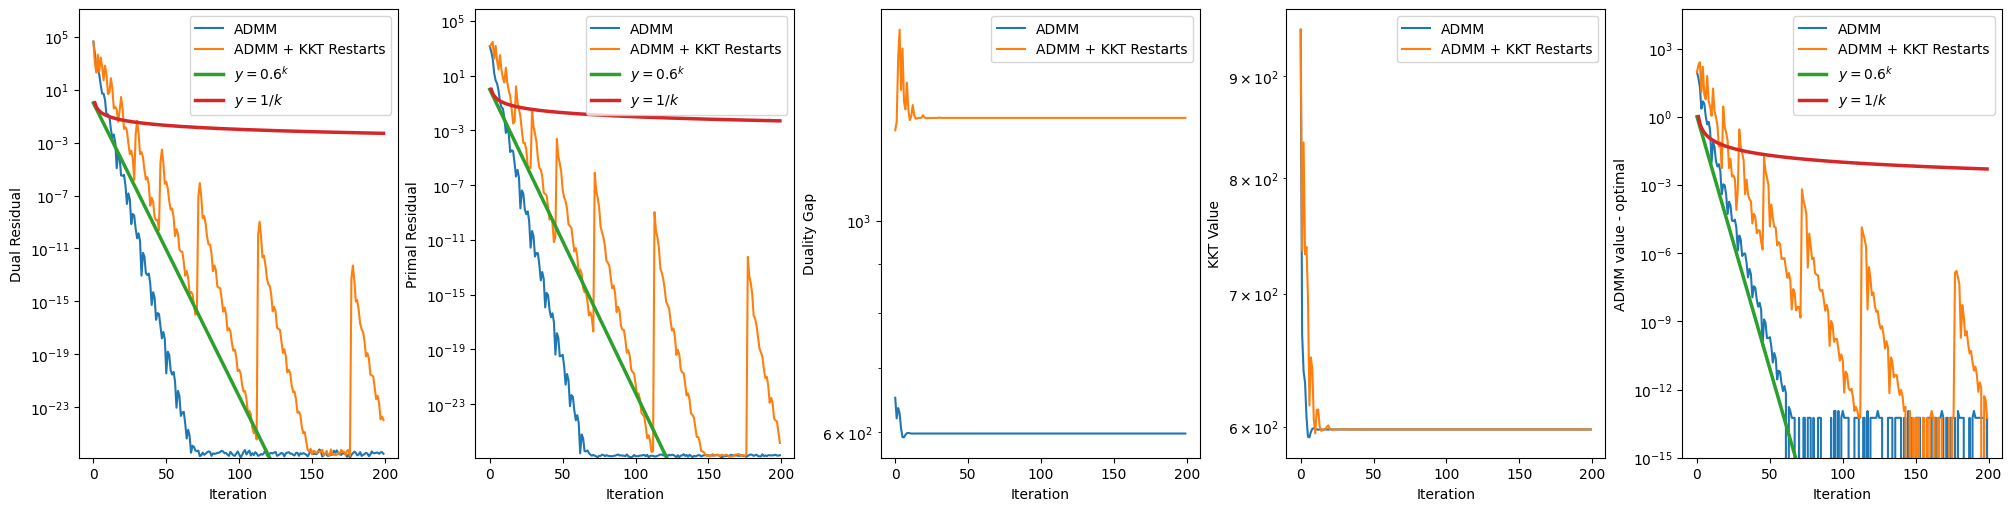

In [8]:
fig, ax = plt.subplots(1, 5, figsize=(20,5), constrained_layout=True)

# NOTE
# ADMM

ax[0].plot(dual_residual, label='ADMM')
ax[0].set_yscale('log')
ax[0].set_ylabel('Dual Residual')
ax[0].set_xlabel('Iteration')
ax[0].legend()

ax[1].plot(primal_residual, label='ADMM')
ax[1].set_yscale('log')
ax[1].set_ylabel('Primal Residual')
ax[1].set_xlabel('Iteration')
ax[1].legend()

ax[2].plot(duality_gap, label='ADMM')
ax[2].set_yscale('log')
ax[2].set_ylabel('Duality Gap')
ax[2].set_xlabel('Iteration')
ax[2].legend()

ax[3].plot(KKT_valus, label='ADMM')
ax[3].set_yscale('log')
ax[3].set_ylabel('KKT Value')
ax[3].set_xlabel('Iteration')
ax[3].legend()

ax[4].plot(value_ADMM, label='ADMM')
ax[4].set_yscale('log')
ax[4].set_ylabel('ADMM value - optimal')
ax[4].set_xlabel('Iteration')
ax[4].legend()


# NOTE
# ADMM + KKT Restarts

ax[0].plot(dual_residual_rest, label='ADMM + KKT Restarts')
ax[0].set_yscale('log')
ax[0].set_ylabel('Dual Residual')
ax[0].set_xlabel('Iteration')
ax[0].legend()

ax[1].plot(primal_residual_rest, label='ADMM + KKT Restarts')
ax[1].set_yscale('log')
ax[1].set_ylabel('Primal Residual')
ax[1].set_xlabel('Iteration')
ax[1].legend()

ax[2].plot(duality_gap_res, label='ADMM + KKT Restarts')
ax[2].set_yscale('log')
ax[2].set_ylabel('Duality Gap')
ax[2].set_xlabel('Iteration')
ax[2].legend()

ax[3].plot(KKT_valus_rest, label='ADMM + KKT Restarts')
ax[3].set_yscale('log')
ax[3].set_ylabel('KKT Value')
ax[3].set_xlabel('Iteration')
ax[3].legend()

ax[4].plot(value_ADMM_restarts, label='ADMM + KKT Restarts')
ax[4].set_yscale('log')
ax[4].set_ylabel('ADMM value - optimal')
ax[4].set_xlabel('Iteration')
ax[4].legend()

# Plot against a linear convergence
k_value = np.arange(0, 200, 1)
y_value = 0.6 ** k_value

ax[0].plot(y_value, label=r"$y=0.6^k$", linewidth=2.5)
ax[0].legend()

ax[1].plot(y_value, label=r"$y=0.6^k$", linewidth=2.5)
ax[1].legend()

# ax[2].plot(y_value, label=r"$y=0.6^k$", linewidth=2.5)
# ax[2].legend()

# ax[3].plot(y_value, label=r"$y=0.6^k$", linewidth=2.5)
# ax[3].legend()

ax[4].plot(y_value, label=r"$y=0.6^k$", linewidth=2.5)
ax[4].legend()

# Plot against a sublinear convergence
k_value = np.arange(0, 200, 1)
y_value = 1 / k_value

ax[0].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[0].legend()

ax[1].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[1].legend()

# ax[2].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
# ax[2].legend()

# ax[3].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
# ax[3].legend()

ax[4].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[4].legend()


# Setting the y-axis limit for visual convinience
ax[0].set_ylim(min(dual_residual))
ax[1].set_ylim(min(primal_residual))
ax[2].set_ylim(0)
# ax[3].set_ylim(min(KKT_valus))
ax[4].set_ylim(1e-15)

min $c^T x$ $\\$
s.t. $Ax+s = b$ $\\$
$s \in C$ $\\$
where $C = \{0\}^{n_{eq}} \text{ x } R_+^{ineq}$

ADMM:
$$x^{k+1} = argmin_x \{c^Tx + (\rho / 2)||Ax+s^k-b - (1/\rho)y^k||_2^2 \} \\
s^{k+1} = argmin_{\{s\in C\}} \{(\rho/2)||Ax^{k+1} + s - b - (1/\rho)y^k||_2^2\} \\
y^{k+1} = y^k - \rho (Ax^{k+1} + s^{k+1} -b) \\
\hat{y}^{k+1} = y^k - \rho (Ax^{k+1} + s^{k} -b)
$$

In [9]:
def ADMM_new(c, A, b, u, l, x, s, y, rho, n, m):
    var1 = cp.Variable(x.shape[0])
    constraint1 = []
    objective = cp.Minimize(c.T@var1 + (rho/2)*cp.sum_squares(A@var1+s-b-(1/rho)*y))
    prob1 = cp.Problem(objective, constraint1)
    prob1.solve()
    x_next = var1.value
    
    var2 = cp.Variable(s.shape[0])
    constraint2 = [var2[:m] == 0, var2[m:] >= 0]
    objective = cp.Minimize((rho/2)*cp.sum_squares(A@x_next + var2 - b - (1/rho)*y))
    prob2 = cp.Problem(objective, constraint2)
    prob2.solve()
    s_next = var2.value
    
    y_next = y - rho*(A@x_next + s_next - b)
    y_hat_next = y - rho*(A@x_next + s - b)
    
    z_hat_next = [x_next, s_next, y_hat_next]
    z_next = [x_next, s_next, y_next]
    
    return z_hat_next, z_next

Use:
$KKT_w(z) = \sqrt{w^2 ||Ax + s - b||_2^2 + (1/w^2)||c - (A^T+B^T)y||_2^2 + (b^Ty-c^Tx)^2 }\\$
where $B = [O, I, I]$, and $I$ the identity matrix of size n amd $O$ is a matrix of all zeros of size (m,n)

Should be:
$KKT_w(z) = \sqrt{w^2 ||Ax + s - b||_2^2 + (1/w^2)||c + (A^T+B^T)y||_2^2 + (b^Ty-c^Tx)^2 }\\$

Note: For the second KKT, the second norm is different then in paper

Note: The second norm ommits the dual variable corresponding to the 

In [10]:
def KKT_error_new(w, c, A, b, x, s, y, m, n):
    
    norm1 = np.linalg.norm(A@x + s - b, 2) ** 2
    
    # Normal dual residual
    b_matrix = np.vstack([np.zeros((m, n)), np.eye(n), np.eye(n)])
    norm2 = np.linalg.norm(c - (A.T + b_matrix.T) @ y, 2) ** 2
    # ADMM dual residual
    # norm2 = np.linalg.norm(nu*U.T@V@(z - z_prev), 2) ** 2
    
    KKT = np.sqrt(w**2 * norm1 + (1/(w**2)) * norm2 + (b.T@y - c.T@x) ** 2)
    
    return KKT

In [11]:
# NOTE
# ADMM

np.random.seed(142)

KKT_valus = []
duality_gap = []
primal_residual = []
dual_residual = []

n = 100
m = 5 * n
A, b, c, x, lambd, nu = generate_randn_data(m, n)
u = np.random.uniform(np.max(x), 5*np.max(x), n) 
l = -u

A = np.vstack([A, np.eye(n), -np.eye(n)])

b = np.hstack([b, u, -l])

iterations = 200



x = np.zeros(n)
s = np.zeros(b.shape[0])
y = np.zeros(b.shape[0])
# NOTE Not sure if rho is the right value, just choose an argibrary one
rho = 0.3

# Implementing CVXPY to get the optimal values
x_cvxpy = cp.Variable(n)
s_cvxpy = cp.Variable(b.shape[0])
objective = cp.Minimize(c.T@x_cvxpy)
constraints = [A@x_cvxpy + s_cvxpy == b, s_cvxpy[m:] >= 0, s_cvxpy[:m] == 0]
problem = cp.Problem(objective, constraints)
problem.solve()
print("Did cvxpy converge =", problem.status)
print("cvxpy value =", c.T @ x_cvxpy.value)




value_ADMM = []

for i in range(iterations):
    # xv_prev used for KKT
    xv_prev = xv
    
    z_hat, z = ADMM_new(c, A, b, u, l, x, s, y, rho, n, m)
    
    x = z[0]
    s = z[1]
    y = z[2]
    
    value_ADMM.append(abs(c@x - problem.value))
    
    KKT = KKT_error_new(rho, c, A, b, x, s, y, m, n)
    KKT_valus.append(KKT)
    
    # Normal Duality Gap
    duality_gap.append(abs((b.T@y - c.T@x)))
    
    # Normalized Duality Gap
    # duality_gap.append(np.sqrt((q.T@(nu*y) + l.T@lam_plus - u.T@lam_minus - c.T@x)**2)/np.sqrt((c.T@x)**2))
    
    
    primal_residual.append(np.linalg.norm(A@x + s - b)**2)
    
    # Normal Dual Residual
    # dual_residual.append(np.linalg.norm(c - K.T @ (nu*y) - lam_KKT, 2) ** 2)
    
    # ADMM Dual Residual
    # dual_residual.append(np.linalg.norm(c - A.T @ y, 2))
    b_matrix = np.vstack([np.zeros((m,n)), np.eye(n), np.eye(n)])
    dual_residual.append(np.linalg.norm(c + (A.T+b_matrix.T) @ y, 2))
    
    # dual_residual.append(np.linalg.norm(nu * U.T@V@(z[1]- xv_prev),2)**2)
    
    # if value_ADMM[i] <= 1e-10:
    #     print("stoped iterations at index =", i)
    #     break
print("ADMM value =", c.T @ x)

Did cvxpy converge = optimal
cvxpy value = -305.4625445888135
ADMM value = -305.46254458881344


In [12]:
# NOTE
# ADMM + Restarts

np.random.seed(142)

value_ADMM_restarts = []
KKT_valus_rest = []
duality_gap_res = []
primal_residual_rest = []
dual_residual_rest = []

n = 100
m = 5 * n
A, b, c, x_, lambd, nu = generate_randn_data(m, n)
u = np.random.uniform(np.max(x_), 5*np.max(x_), n) 
l = -u

A = np.vstack([A, np.eye(n), -np.eye(n)])

b = np.hstack([b, u, -l])

# Total iterations Number
iterations = 200



x = np.zeros(n)
s = np.zeros(b.shape[0])
y = np.zeros(b.shape[0])
# NOTE Not sure if nu is the right value, just choose an argibrary one
rho = 0.3

# Implementing CVXPY to get the optimal values
x_cvxpy = cp.Variable(n)
s_cvxpy = cp.Variable(b.shape[0])
objective = cp.Minimize(c.T@x_cvxpy)
constraints = [A@x_cvxpy + s_cvxpy == b, s_cvxpy[m:] >= 0, s_cvxpy[:m] == 0]
problem = cp.Problem(objective, constraints)
problem.solve()
print("Did cvxpy converge =", problem.status)
print("cvxpy value =", c.T @ x_cvxpy.value)

z = np.zeros(500, dtype=object)
z_bar = 0



# Initializing starter KKT values
KKT_prev = np.zeros(20, dtype=object)

KKT = KKT_error_new(rho, c, A, b, x, s, y, m, n)
KKT_prev[0] = -np.inf
KKT_prev[1] = -np.inf
KKT_n = -np.inf


# Beginning the iterations. I have here both the KKT restarts and the fixed interval restarts. The fixed interval restarts are commented out. In later versions I will 
# seperate the two and make them two seperate instances, here for simplicity they are put together
for f in range(1,2):
    # Initialize values
    count = 0
    x = np.zeros(n)
    s = np.zeros(b.shape[0])
    y = np.zeros(b.shape[0])
    
    # Outer loop
    for i in range(200):
        # Reset values
        z[i] = z_bar
        
        x_bar = 0
        s_bar = 0
        y_bar = 0
        
        t = 0
        
        # Inner loop
        while not ((KKT <= 0.8 * KKT_n and KKT > KKT_prev[0]) or (KKT <= 0.2 * KKT_n) or (t >= max(0.36 * count,1))):
        # for g in range(f):
            # xv_prev used for KKT
            x_prev = x
            
            # ADMM
            z_hat, z_admm = ADMM_new(c, A, b, u, l, x, s, y, rho, n, m)

            # dual_residual_rest.append(np.linalg.norm(nu * U.T@V@(z_admm[1] - xv_prev),2)**2)
            
            x = z_admm[0]
            s = z_admm[1]
            y = z_admm[2]

            value_ADMM_restarts.append(abs(c@x - problem.value))
            diff = abs(c@x - problem.value)
            
            x_bar = (t/(1+t)) * x_bar + (1/(1+t)) * z_hat[0]
            s_bar = (t/(1+t)) * s_bar + (1/(1+t)) * z_hat[1]
            y_bar = (t/(1+t)) * y_bar + (1/(1+t)) * z_hat[2]
            
            KKT = KKT_error_new(rho, c, A, b, x, s, y, m, n)
            KKT_valus_rest.append(KKT)
            
            # Normal Duality Gap
            duality_gap_res.append(abs((b.T@y - c.T@x)))
            
            # Normalized Duality Gap
            # duality_gap_res.append(np.sqrt((q.T@y + l.T@lam_plus - u.T@lam_minus - c.T@x)**2)/np.sqrt((c.T@x)**2))
            
            primal_residual_rest.append(np.linalg.norm(A@x + s - b)**2)
            
            # Normal Dual Residual
            # dual_residual_rest.append(np.linalg.norm(c - K.T @ y - lam, 2) ** 2)
            
            # ADMM Dual Residual
            # dual_residual_rest.append(np.linalg.norm(nu * U.T@V@(z_admm[1] - xv_prev),2)**2)
            b_matrix = np.vstack([np.zeros((m,n)), np.eye(n), np.eye(n)])
            dual_residual_rest.append(np.linalg.norm(c + (A.T+b_matrix.T) @ y, 2))
            
            
            KKT_prev[0] = KKT_prev[1]
            KKT_prev[1] = KKT
            
            # Update count
            t += 1
            count += 1
            
            if count >= iterations:
                break
            
            # if (value_ADMM_restarts[count] <= 1e-13):
            # if (diff <= 1e-10):
            #     # print("stoped iterations at index =", i)
            #     break
        # if value_ADMM_restarts[count] <= 1e-13:
        # if diff <= 1e-10:
        #     print("stoped iterations at index =", i)
        #     print("count =", count)
        #     print("f =", f)
        #     break
        if count >= iterations:
            print("For f =", f, "we go over 100 iterations")
            break
        
        # Outer Loop update
        KKT_n = KKT
        x = x_bar
        s = s_bar
        y = y_bar
        z_bar = [x, s, y]

print("count =", count)
print("ADMM with restarts value =", c.T @ x)

Did cvxpy converge = optimal
cvxpy value = -305.4625445888135
For f = 1 we go over 100 iterations
count = 200
ADMM with restarts value = -305.46254458881356


C:\Users\baice\AppData\Local\Temp\ipykernel_46196\1644122487.py:90: RuntimeWarning: divide by zero encountered in divide
  y_value = 1 / k_value


(1e-15, 79689.77732432476)

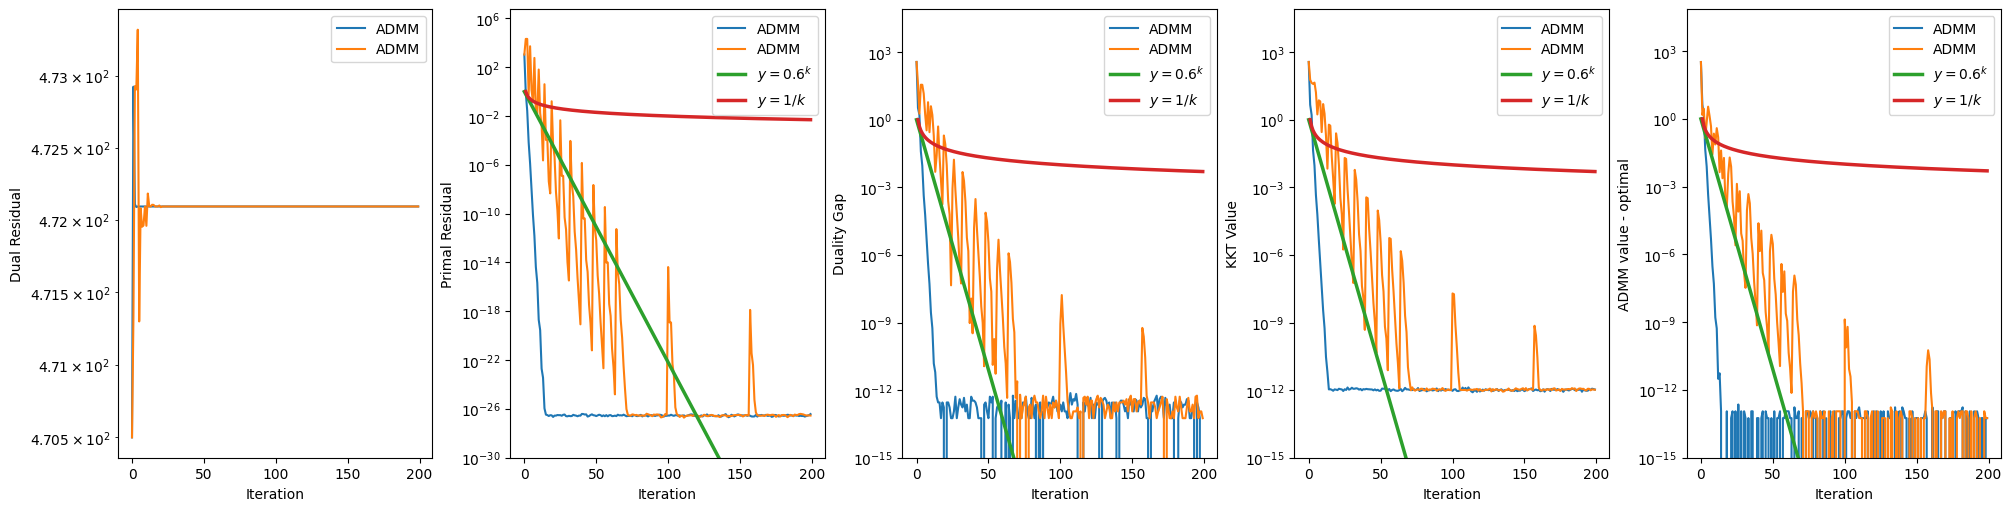

In [13]:

fig, ax = plt.subplots(1, 5, figsize=(20,5), constrained_layout=True)

# NOTE
# ADMM

ax[0].plot(dual_residual, label='ADMM')
ax[0].set_yscale('log')
ax[0].set_ylabel('Dual Residual')
ax[0].set_xlabel('Iteration')
ax[0].legend()

ax[1].plot(primal_residual, label='ADMM')
ax[1].set_yscale('log')
ax[1].set_ylabel('Primal Residual')
ax[1].set_xlabel('Iteration')
ax[1].legend()

ax[2].plot(duality_gap, label='ADMM')
ax[2].set_yscale('log')
ax[2].set_ylabel('Duality Gap')
ax[2].set_xlabel('Iteration')
ax[2].legend()

ax[3].plot(KKT_valus, label='ADMM')
ax[3].set_yscale('log')
ax[3].set_ylabel('KKT Value')
ax[3].set_xlabel('Iteration')
ax[3].legend()

ax[4].plot(value_ADMM, label='ADMM')
ax[4].set_yscale('log')
ax[4].set_ylabel('ADMM value - optimal')
ax[4].set_xlabel('Iteration')
ax[4].legend()

# NOTE
# ADMM + KKT Restarts
ax[0].plot(dual_residual_rest, label='ADMM')
ax[0].set_yscale('log')
ax[0].set_ylabel('Dual Residual')
ax[0].set_xlabel('Iteration')
ax[0].legend()

ax[1].plot(primal_residual_rest, label='ADMM')
ax[1].set_yscale('log')
ax[1].set_ylabel('Primal Residual')
ax[1].set_xlabel('Iteration')
ax[1].legend()

ax[2].plot(duality_gap_res, label='ADMM')
ax[2].set_yscale('log')
ax[2].set_ylabel('Duality Gap')
ax[2].set_xlabel('Iteration')
ax[2].legend()

ax[3].plot(KKT_valus_rest, label='ADMM')
ax[3].set_yscale('log')
ax[3].set_ylabel('KKT Value')
ax[3].set_xlabel('Iteration')
ax[3].legend()

ax[4].plot(value_ADMM_restarts, label='ADMM')
ax[4].set_yscale('log')
ax[4].set_ylabel('ADMM value - optimal')
ax[4].set_xlabel('Iteration')
ax[4].legend()


# Plot against a linear convergence
k_value = np.arange(0, 200, 1)
y_value = 0.6 ** k_value

# ax[0].plot(y_value, label=r"$y=0.6^k$", linewidth=2.5)
# ax[0].legend()

ax[1].plot(y_value, label=r"$y=0.6^k$", linewidth=2.5)
ax[1].legend()

ax[2].plot(y_value, label=r"$y=0.6^k$", linewidth=2.5)
ax[2].legend()

ax[3].plot(y_value, label=r"$y=0.6^k$", linewidth=2.5)
ax[3].legend()

ax[4].plot(y_value, label=r"$y=0.6^k$", linewidth=2.5)
ax[4].legend()

# Plot against a sublinear convergence
k_value = np.arange(0, 200, 1)
y_value = 1 / k_value

ax[1].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[1].legend()

ax[2].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[2].legend()

ax[3].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[3].legend()

ax[4].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[4].legend()


ax[4].set_ylim(1e-15)
ax[1].set_ylim(1e-30)
ax[2].set_ylim(1e-15)
ax[3].set_ylim(1e-15)

Importing problems from Netlib LP

In [14]:
import pulp
import gurobipy as gp
import scipy.io
from scipy.sparse import csc_matrix
np.set_printoptions(threshold=np.inf, linewidth=200)

Problem is in format of:

min $c^T x$

s.t. $Ax = b$

$x\geq0$

Importing Data

In [47]:
# Sublinear in both ADMM and Restart ADMM
mat_data = scipy.io.loadmat("C:/Users/baice/Downloads/ADLITTLE.mat")
A_mat = mat_data['A'].toarray()
b_mat = mat_data['b'].flatten()
c_mat = mat_data['c'].flatten()

x = cp.Variable(A_mat.shape[1])
objective = cp.Minimize(c_mat.T @ x)
constraints = [A_mat @ x == b_mat, x >= 0]
problem = cp.Problem(objective, constraints)
problem.solve()
print(objective.value)

225494.96428901353


In [56]:
mat_data = scipy.io.loadmat("C:/Users/baice/Downloads/BLEND.mat")
A_mat = mat_data['A'].toarray()
b_mat = mat_data['b'].flatten()
c_mat = mat_data['c'].flatten()

x = cp.Variable(A_mat.shape[1])
objective = cp.Minimize(c_mat.T @ x)
constraints = [A_mat @ x == b_mat, x >= 0]
problem = cp.Problem(objective, constraints)
problem.solve()
print(objective.value)
# use to check
print(constraints[0].dual_value)
print(np.linalg.norm(np.minimum(c_mat+A_mat.T@constraints[0].dual_value,0),2))

-30.812149432515863
[ 3.6327  3.492   2.939   2.939   3.0356  2.9416  2.      1.359   2.75    2.75    4.3339  4.3832  3.25    4.3962  4.3711  4.3962  2.7796  2.6141  5.2043  5.03    2.8156  4.3962  4.7485  5.8632
  4.7353  2.75    4.9695  3.4442  2.5194  5.3684  5.4751 -0.0434  1.0821  2.939   4.5591  3.2118  2.75    4.3563  0.      0.04    0.      0.0132  0.01    0.      0.56    0.      0.0417  0.
  0.      0.      0.4442  0.      0.0407  0.      0.0103  0.2169  0.     -0.      0.0379  0.08    0.      0.2534  0.057   0.0757  0.661   0.7551  0.     -0.      0.      1.2281  0.8304 -0.
  0.0898  0.3572]
1.8292509771163633e-08


In [6]:
mat_data = scipy.io.loadmat("C:/Users/baice/Downloads/BEACONFD.mat")
A_mat = mat_data['A'].toarray()
b_mat = mat_data['b'].flatten()
c_mat = mat_data['c'].flatten()

x = cp.Variable(A_mat.shape[1])
objective = cp.Minimize(c_mat.T @ x)
constraints = [A_mat @ x == b_mat, x >= 0]
problem = cp.Problem(objective, constraints)
problem.solve()
print(objective.value)

33592.48573814446


In [ ]:
mat_data = scipy.io.loadmat("C:/Users/baice/Downloads/QAP15.mat")
A_mat = mat_data['A'].toarray()
b_mat = mat_data['b'].flatten()
c_mat = mat_data['c'].flatten()

x = cp.Variable(A_mat.shape[1])
objective = cp.Minimize(c_mat.T @ x)
constraints = [A_mat @ x == b_mat, x >= 0]
problem = cp.Problem(objective, constraints)
problem.solve()
print(objective.value)

New KKT as only positive constraint

In [16]:
def KKT_error_new_mat(w, c, A, b, x, s, y, m, n):
    temp = A@x
    temp = temp + s
    temp = temp - b
    norm1 = np.linalg.norm(A@x + s - b, 2) ** 2
    
    # Normal dual residual
    b_matrix = np.vstack([np.zeros((m, n)), np.eye(n)])
    norm2 = np.linalg.norm(c - (A.T + b_matrix.T) @ y, 2) ** 2
    # ADMM dual residual
    # norm2 = np.linalg.norm(nu*U.T@V@(z - z_prev), 2) ** 2
    
    KKT = np.sqrt(w**2 * norm1 + (1/(w**2)) * norm2 + (b.T@y - c.T@x) ** 2)
    
    return KKT

In [84]:
def ADMM_new_mat(c, A, b, x, s, y, rho, n, m, lu):
    # var1 = cp.Variable(x.shape[0])
    # constraint1 = []
    # objective = cp.Minimize(c.T@var1 + (rho/2)*cp.sum_squares(A@var1+s-b-(1/rho)*y))
    # prob1 = cp.Problem(objective, constraint1)
    # prob1.solve()
    # x_next = var1.value
    
    # C = (rho) * A.T @ A
    d = -c  - rho * A.T @ (s - b - (1/rho) * y)
    x_next = lu.solve(d)
    
    # var2 = cp.Variable(s.shape[0])
    # constraint2 = [var2[:m] == 0, var2[m:] >= 0]
    # objective = cp.Minimize((rho/2)*cp.sum_squares(A@x_next + var2 - b - (1/rho)*y))
    # prob2 = cp.Problem(objective, constraint2)
    # prob2.solve()
    # s_next = var2.value
    
    s_next = np.zeros(s.shape[0])
    term = -(A @ x_next - b - (1/rho) * y)
    for i in range(len(s_next[m:])):
        s_next[i+m] = max(0, term[i+m])
        
    
    y_next = y - rho*(A@x_next + s_next - b)
    y_hat_next = y - rho*(A@x_next + s - b)
    
    z_hat_next = [x_next, s_next, y_hat_next]
    z_next = [x_next, s_next, y_next]
    
    return z_hat_next, z_next

min $c^T x + (\rho/2) ||Ax + s - b - (1/ \rho)y ||^2_2$


$c + \rho A^T (Ax + s - b - (1/\rho)y )  = 0$

$c + \rho A^T A x + \rho A^T (s - b - (1/\rho) y) = 0$

$\rho A^T A x = -c + (1/2) A^T y - \rho A^T (s - b - (1/\rho) y)$

In [85]:
# NOTE
# ADMM

np.random.seed(142)

KKT_valus = []
duality_gap = []
primal_residual = []
dual_residual = []

n = A_mat.shape[1]
m = A_mat.shape[0]

# Addign slack variables
A = np.vstack([A_mat, -np.eye(n)])

b = np.hstack([b_mat, np.zeros(n)])

c = c_mat

iterations = 5000



x = np.zeros(n)
s = np.zeros(b.shape[0])
y = np.zeros(b.shape[0])
# NOTE Not sure if rho is the right value, just choose an argibrary one
rho = 0.3

# Implementing CVXPY to get the optimal values
x_cvxpy = cp.Variable(n)
s_cvxpy = cp.Variable(b.shape[0])
objective = cp.Minimize(c.T@x_cvxpy)
constraints = [A@x_cvxpy + s_cvxpy == b, s_cvxpy[m:] >= 0, s_cvxpy[:m] == 0]
problem = cp.Problem(objective, constraints)
problem.solve()
print("Did cvxpy converge =", problem.status)
print("cvxpy value =", c.T @ x_cvxpy.value)


lu = splu(rho * A.T @ A)

value_ADMM = []

for i in range(iterations):
    # xv_prev used for KKT
    # xv_prev = xv
    
    z_hat, z = ADMM_new_mat(c, A, b, x, s, y, rho, n, m, lu)
    
    x = np.copy(z[0])
    s = np.copy(z[1])
    y = np.copy(z[2])
    
    value_ADMM.append(abs(c@x - problem.value))
    
    KKT = KKT_error_new_mat(rho, c, A, b, x, s, y, m, n)
    KKT_valus.append(KKT)
    
    # Normal Duality Gap
    duality_gap.append(abs((b.T@y - c.T@x)))
    
    # Normalized Duality Gap
    # duality_gap.append(np.sqrt((q.T@(nu*y) + l.T@lam_plus - u.T@lam_minus - c.T@x)**2)/np.sqrt((c.T@x)**2))
    
    
    primal_residual.append(np.linalg.norm(A@x + s - b)**2)
    
    # Normal Dual Residual
    # dual_residual.append(np.linalg.norm(c - K.T @ (nu*y) - lam_KKT, 2) ** 2)
    
    # ADMM Dual Residual
    # dual_residual.append(np.linalg.norm(c - A.T @ y, 2))
    b_matrix = np.vstack([np.zeros((m,n)), np.eye(n)])
    # dual_residual.append(np.linalg.norm(c + (A.T+b_matrix.T) @ y, 2))
    # This is the dual feasibility violation
    dual_residual.append(np.linalg.norm(np.minimum(c-(A.T+b_matrix.T) @ y, 0)))
    
    
    # dual_residual.append(np.linalg.norm(nu * U.T@V@(z[1]- xv_prev),2)**2)
    
    # if value_ADMM[i] <= 1e-10:
    #     print("stoped iterations at index =", i)
    #     break
print("ADMM value =", c.T @ x)
# For 1,000 iterations for BLEND
# -31.59654940123112 22.1s both cvxpy
# -31.59654940123112 12.8s First closed form
# -31.59654940123112 1.4s both closed form

Did cvxpy converge = optimal
cvxpy value = -30.81214944414279


C:\Users\baice\AppData\Local\Temp\ipykernel_46196\1012727948.py:42: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = splu(rho * A.T @ A)


ADMM value = -30.703600021401794


In [40]:
print(y)

[-3.6305 -3.4903 -2.9324 -2.9324 -3.029  -2.9598 -1.9999 -1.3587 -2.7499 -2.7498 -4.3446 -4.388  -3.2506 -4.4018 -4.3775 -4.4017 -2.6039 -2.6138 -5.2168 -5.0374 -2.8155 -4.4017 -4.7519 -5.8018
 -4.6939 -2.7499 -4.9771 -3.4444 -2.5194 -5.3494 -5.4443 -0.4288 -1.1823 -2.9324 -4.5596 -3.2233 -2.7499 -4.3007 -0.0002 -0.0404 -0.0003 -0.0136 -0.011  -0.0013 -0.5101  0.0039 -0.0413 -0.
  0.0001 -0.0002 -0.4344  0.0011 -0.0407  0.     -0.006  -0.2165  0.      0.0002 -0.0381 -0.074   0.     -0.2534 -0.0343 -0.0318 -0.6676 -0.7368  0.0003 -0.0004 -0.     -1.2166 -0.8257 -0.0002
 -0.1086 -0.36    0.     -0.5101  0.     -0.0413  0.      0.      0.     -0.4344  0.     -0.0407  0.     -0.006  -0.2165  0.      0.     -0.0381 -0.074  -0.     -0.2534 -0.0343 -0.0318 -0.6676
 -0.7368  0.      0.      0.     -1.2166 -0.8257  0.     -0.1086 -0.36    0.      0.      0.      0.      0.      0.     -0.0115  0.     -0.0242  0.     -0.0243 -0.     -0.0188  0.      0.
  0.     -0.1556  0.      0.      0.     -0

In [89]:
# NOTE
# ADMM + Restarts

np.random.seed(142)

value_ADMM_restarts = []
KKT_valus_rest = []
duality_gap_res = []
primal_residual_rest = []
dual_residual_rest = []

n = A_mat.shape[1]
m = A_mat.shape[0]

# Addign slack variables
A = np.vstack([A_mat, -np.eye(n)])

b = np.hstack([b_mat, np.zeros(n)])

c = c_mat

# Total iterations Number
iterations = 5000



x = np.zeros(n)
s = np.zeros(b.shape[0])
y = np.zeros(b.shape[0])
# NOTE Not sure if nu is the right value, just choose an argibrary one
rho = 0.3

# Implementing CVXPY to get the optimal values
x_cvxpy = cp.Variable(n)
s_cvxpy = cp.Variable(b.shape[0])
objective = cp.Minimize(c.T@x_cvxpy)
constraints = [A@x_cvxpy + s_cvxpy == b, s_cvxpy[m:] >= 0, s_cvxpy[:m] == 0]
problem = cp.Problem(objective, constraints)
problem.solve()
print("Did cvxpy converge =", problem.status)
print("cvxpy value =", c.T @ x_cvxpy.value)

# z = np.zeros(500, dtype=object)
z = []
z_bar = 0



# Initializing starter KKT values
KKT_prev = np.zeros(20, dtype=object)

KKT = KKT_error_new_mat(rho, c, A, b, x, s, y, m, n)
KKT_prev[0] = -np.inf
KKT_prev[1] = -np.inf
KKT_n = -np.inf

lu = splu(rho * A.T @ A)

# Beginning the iterations. I have here both the KKT restarts and the fixed interval restarts. The fixed interval restarts are commented out. In later versions I will 
# seperate the two and make them two seperate instances, here for simplicity they are put together
for f in range(1,2):
    # Initialize values
    count = 0
    x = np.zeros(n)
    s = np.zeros(b.shape[0])
    y = np.zeros(b.shape[0])
    
    # Outer loop
    for i in range(iterations):
        # Reset values
        z.append(z_bar)
        
        # print("outside", not ((KKT <= 0.8 * KKT_n and KKT > KKT_prev[0]) or (KKT <= 0.2 * KKT_n) or (t >= max(0.36 * count,1))) or (t != 0))
        x_bar = 0
        s_bar = 0
        y_bar = 0
        
        t = 0
        
        # Inner loop
        # while not ((KKT <= 0.8 * KKT_n and KKT > KKT_prev[0])) or not (KKT <= 0.2 * KKT_n) or not (t >= max(0.36 * count,1)):
        while not ((KKT <= 0.8 * KKT_n and KKT > KKT_prev[0]) or (KKT <= 0.2 * KKT_n) or (t >= max(0.36 * count,1))):
        # for g in range(f):
            # xv_prev used for KKT
            x_prev = x
            
            # ADMM
            z_hat, z_admm = ADMM_new_mat(c, A, b, x, s, y, rho, n, m, lu)

            # dual_residual_rest.append(np.linalg.norm(nu * U.T@V@(z_admm[1] - xv_prev),2)**2)
            
            x = z_admm[0]
            s = z_admm[1]
            y = z_admm[2]

            value_ADMM_restarts.append(abs(c@x - problem.value))
            diff = abs(c@x - problem.value)
            # print("inside", not ((KKT <= 0.8 * KKT_n and KKT > KKT_prev[0]) or (KKT <= 0.2 * KKT_n) or (t >= max(0.36 * count,1))))
            x_bar = (t/(1+t)) * x_bar + (1/(1+t)) * z_hat[0]
            s_bar = (t/(1+t)) * s_bar + (1/(1+t)) * z_hat[1]
            y_bar = (t/(1+t)) * y_bar + (1/(1+t)) * z_hat[2]
            
            # if KKT_error_new_mat(rho, c, A, b, x, s, y, m, n) < KKT_error_new_mat(rho, c, A, b, x_bar, s_bar, y_bar, m, n):
            #     KKT = KKT_error_new_mat(rho, c, A, b, x, s, y, m, n)
            #     original = True
            # else:
            #     KKT = KKT_error_new_mat(rho, c, A, b, x_bar, s, y, m, n)
            #     original = False
            
            KKT = KKT_error_new_mat(rho, c, A, b, x, s, y, m, n)
            KKT_valus_rest.append(KKT)
            
            # Normal Duality Gap
            duality_gap_res.append(abs((b.T@y - c.T@x)))
            
            # Normalized Duality Gap
            # duality_gap_res.append(np.sqrt((q.T@y + l.T@lam_plus - u.T@lam_minus - c.T@x)**2)/np.sqrt((c.T@x)**2))
            
            primal_residual_rest.append(np.linalg.norm(A@x + s - b)**2)
            
            # Normal Dual Residual
            # dual_residual_rest.append(np.linalg.norm(c - K.T @ y - lam, 2) ** 2)
            
            # ADMM Dual Residual
            # dual_residual_rest.append(np.linalg.norm(nu * U.T@V@(z_admm[1] - xv_prev),2)**2)
            b_matrix = np.vstack([np.zeros((m,n)), np.eye(n)])
            # dual_residual_rest.append(np.linalg.norm(c + (A.T+b_matrix.T) @ y, 2))
            # This is the dual feasibility violation
            dual_residual_rest.append(np.linalg.norm(np.minimum(c - (A.T+b_matrix.T) @ y, 0)))
            
            
            KKT_prev[0] = np.copy(KKT_prev[1])
            KKT_prev[1] = KKT
            
            # Update count
            t += 1
            count += 1
            
            if count >= iterations:
                break
            
            # if (value_ADMM_restarts[count] <= 1e-13):
            # if (diff <= 1e-10):
            #     # print("stoped iterations at index =", i)
            #     break
        # if value_ADMM_restarts[count] <= 1e-13:
        # if diff <= 1e-10:
        #     print("stoped iterations at index =", i)
        #     print("count =", count)
        #     print("f =", f)
        #     break
        if count >= iterations:
            print("For f =", f, "we go over 100 iterations")
            break
        
        # Outer Loop update
        # if original:
        #     x = x
        #     s = s
        #     y = y
        # else:
        #     x = x_bar
        #     s = s_bar
        #     y = y_bar
        # KKT_n = KKT_error_new_mat(rho, c, A, b, x, s, y, m, n)
        KKT_n = KKT
        x = x_bar
        s = s_bar
        y = y_bar
        # print(x_bar)
        # print("test", not ((KKT <= 0.8 * KKT_n and KKT > KKT_prev[0]) or (KKT <= 0.2 * KKT_n) or (t >= max(0.36 * count,1))) or (t != 0))
        z_bar = [x, s, y]

print("count =", count)
print("ADMM with restarts value =", c.T @ x)
# For 5,000 iterations for BLEND
# -30.812138920211172 2m 10.1s
# -30.81213892021161 8.9s

Did cvxpy converge = optimal
cvxpy value = -30.81214944414279


C:\Users\baice\AppData\Local\Temp\ipykernel_46196\3314099700.py:57: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = splu(rho * A.T @ A)


For f = 1 we go over 100 iterations
count = 5000
ADMM with restarts value = -30.81213892021161


In [42]:
print(y)

[-3.6327 -3.492  -2.939  -2.939  -3.0356 -2.9416 -2.     -1.359  -2.75   -2.75   -4.3339 -4.3832 -3.25   -4.3962 -4.377  -4.3962 -2.5961 -2.6141 -5.2051 -5.03   -2.8156 -4.3962 -4.7485 -5.8631
 -4.7353 -2.75   -4.9695 -3.4442 -2.5194 -5.3684 -5.4751  0.0432 -1.0821 -2.939  -4.5591 -3.2118 -2.75   -4.2843 -0.     -0.04   -0.     -0.0132 -0.01   -0.     -0.56    0.     -0.0417 -0.
  0.      0.     -0.4442 -0.     -0.0407 -0.     -0.0103 -0.2169  0.      0.     -0.0379 -0.08   -0.     -0.2534 -0.0261 -0.0231 -0.661  -0.7551 -0.      0.      0.     -1.2281 -0.8304 -0.
 -0.0898 -0.3572  0.     -0.56    0.     -0.0417  0.      0.      0.     -0.4442  0.     -0.0407  0.     -0.0103 -0.2169 -0.     -0.     -0.0379 -0.08   -0.     -0.2534 -0.0261 -0.0231 -0.661
 -0.7551  0.      0.      0.     -1.2281 -0.8304  0.     -0.0898 -0.3572 -0.     -0.      0.      0.     -0.      0.     -0.0034  0.     -0.0192 -0.     -0.0192  0.     -0.0273  0.      0.
  0.     -0.1558  0.     -0.     -0.      0.    

In [90]:
# NOTE
# ADMM + Fixed Restarts

np.random.seed(142)

value_ADMM_restarts_fixed = []
KKT_valus_rest_fixed = []
duality_gap_res_fixed = []
primal_residual_rest_fixed = []
dual_residual_rest_fixed = []

n = A_mat.shape[1]
m = A_mat.shape[0]

# Addign slack variables
A = np.vstack([A_mat, -np.eye(n)])

b = np.hstack([b_mat, np.zeros(n)])

c = c_mat

# Total iterations Number
iterations = 10000



x = np.zeros(n)
s = np.zeros(b.shape[0])
y = np.zeros(b.shape[0])
# NOTE Not sure if nu is the right value, just choose an argibrary one
rho = 0.3

# Implementing CVXPY to get the optimal values
x_cvxpy = cp.Variable(n)
s_cvxpy = cp.Variable(b.shape[0])
objective = cp.Minimize(c.T@x_cvxpy)
constraints = [A@x_cvxpy + s_cvxpy == b, s_cvxpy[m:] >= 0, s_cvxpy[:m] == 0]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.CLARABEL, tol_gap_abs=1e-10, tol_gap_rel=1e-10,tol_feas=1e-10, tol_ktratio=1e-10)
print("Did cvxpy converge =", problem.status)
print("cvxpy value =", c.T @ x_cvxpy.value)

# z = np.zeros(500, dtype=object)
z = []
z_bar = 0



# # Initializing starter KKT values
# KKT_prev = np.zeros(20, dtype=object)

# KKT = KKT_error_new_mat(rho, c, A, b, x, s, y, m, n)
# KKT_prev[0] = -np.inf
# KKT_prev[1] = -np.inf
# KKT_n = -np.inf

lu = splu(rho * A.T @ A)

# Beginning the iterations. I have here both the KKT restarts and the fixed interval restarts. The fixed interval restarts are commented out. In later versions I will 
# seperate the two and make them two seperate instances, here for simplicity they are put together
for f in range(1005,1006):
    # Initialize values
    count = 0
    x = np.zeros(n)
    s = np.zeros(b.shape[0])
    y = np.zeros(b.shape[0])
    
    # Outer loop
    for i in range(iterations):
        # Reset values
        z.append(z_bar)
        
        # print("outside", not ((KKT <= 0.8 * KKT_n and KKT > KKT_prev[0]) or (KKT <= 0.2 * KKT_n) or (t >= max(0.36 * count,1))) or (t != 0))
        x_bar = 0
        s_bar = 0
        y_bar = 0
        
        t = 0
        
        # Inner loop
        # while not ((KKT <= 0.8 * KKT_n and KKT > KKT_prev[0])) or not (KKT <= 0.2 * KKT_n) or not (t >= max(0.36 * count,1)):
        # while not ((KKT <= 0.8 * KKT_n and KKT > KKT_prev[0]) or (KKT <= 0.2 * KKT_n) or (t >= max(0.36 * count,1))):
        for g in range(f):
            # xv_prev used for KKT
            x_prev = x
            
            # ADMM
            z_hat, z_admm = ADMM_new_mat(c, A, b, x, s, y, rho, n, m, lu)

            # dual_residual_rest.append(np.linalg.norm(nu * U.T@V@(z_admm[1] - xv_prev),2)**2)
            
            x = z_admm[0]
            s = z_admm[1]
            y = z_admm[2]

            value_ADMM_restarts_fixed.append(abs(c@x - problem.value))
            diff = abs(c@x - problem.value)
            # print("inside", not ((KKT <= 0.8 * KKT_n and KKT > KKT_prev[0]) or (KKT <= 0.2 * KKT_n) or (t >= max(0.36 * count,1))))
            x_bar = (t/(1+t)) * x_bar + (1/(1+t)) * z_hat[0]
            s_bar = (t/(1+t)) * s_bar + (1/(1+t)) * z_hat[1]
            y_bar = (t/(1+t)) * y_bar + (1/(1+t)) * z_hat[2]
            
            # if KKT_error_new_mat(rho, c, A, b, x, s, y, m, n) < KKT_error_new_mat(rho, c, A, b, x_bar, s_bar, y_bar, m, n):
            #     KKT = KKT_error_new_mat(rho, c, A, b, x, s, y, m, n)
            #     original = True
            # else:
            #     KKT = KKT_error_new_mat(rho, c, A, b, x_bar, s, y, m, n)
            #     original = False
            
            # KKT = KKT_error_new_mat(rho, c, A, b, x, s, y, m, n)
            # KKT_valus_rest.append(KKT)
            
            # Normal Duality Gap
            duality_gap_res_fixed.append(abs((b.T@y - c.T@x)))
            
            # Normalized Duality Gap
            # duality_gap_res.append(np.sqrt((q.T@y + l.T@lam_plus - u.T@lam_minus - c.T@x)**2)/np.sqrt((c.T@x)**2))
            
            primal_residual_rest_fixed.append(np.linalg.norm(A@x + s - b)**2)
            
            # Normal Dual Residual
            # dual_residual_rest.append(np.linalg.norm(c - K.T @ y - lam, 2) ** 2)
            
            # ADMM Dual Residual
            # dual_residual_rest.append(np.linalg.norm(nu * U.T@V@(z_admm[1] - xv_prev),2)**2)
            b_matrix = np.vstack([np.zeros((m,n)), np.eye(n)])
            # dual_residual_rest.append(np.linalg.norm(c + (A.T+b_matrix.T) @ y, 2))
            # This is the dual feasibility violation
            dual_residual_rest_fixed.append(np.linalg.norm(np.minimum(c - (A.T+b_matrix.T) @ y, 0)))
            
            
            # KKT_prev[0] = np.copy(KKT_prev[1])
            # KKT_prev[1] = KKT
            
            # Update count
            t += 1
            count += 1
            
            if count >= iterations:
                break
            
            # if (value_ADMM_restarts[count] <= 1e-13):
            # if (diff <= 1e-10):
            #     # print("stoped iterations at index =", i)
            #     break
        # if value_ADMM_restarts[count] <= 1e-13:
        # if diff <= 1e-10:
        #     print("stoped iterations at index =", i)
        #     print("count =", count)
        #     print("f =", f)
        #     break
        if count >= iterations:
            print("For f =", f, "we go over 100 iterations")
            break
        
        # Outer Loop update
        # if original:
        #     x = x
        #     s = s
        #     y = y
        # else:
        #     x = x_bar
        #     s = s_bar
        #     y = y_bar
        # KKT_n = KKT_error_new_mat(rho, c, A, b, x, s, y, m, n)
        # KKT_n = KKT
        x = x_bar
        s = s_bar
        y = y_bar
        # print(x_bar)
        # print("test", not ((KKT <= 0.8 * KKT_n and KKT > KKT_prev[0]) or (KKT <= 0.2 * KKT_n) or (t >= max(0.36 * count,1))) or (t != 0))
        z_bar = [x, s, y]

print("count =", count)
print("ADMM with restarts value =", c.T @ x)
# For 10,000 iterations for BLEND
# -30.81214984662317 5m 15.8s
# -30.81214984662259 11.4s

Did cvxpy converge = optimal
cvxpy value = -30.81214984181018


C:\Users\baice\AppData\Local\Temp\ipykernel_46196\2484604365.py:57: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = splu(rho * A.T @ A)


For f = 1005 we go over 100 iterations
count = 10000
ADMM with restarts value = -30.81214984662259


C:\Users\baice\AppData\Local\Temp\ipykernel_46196\3560031235.py:63: RuntimeWarning: divide by zero encountered in divide
  y_value = 1 / k_value


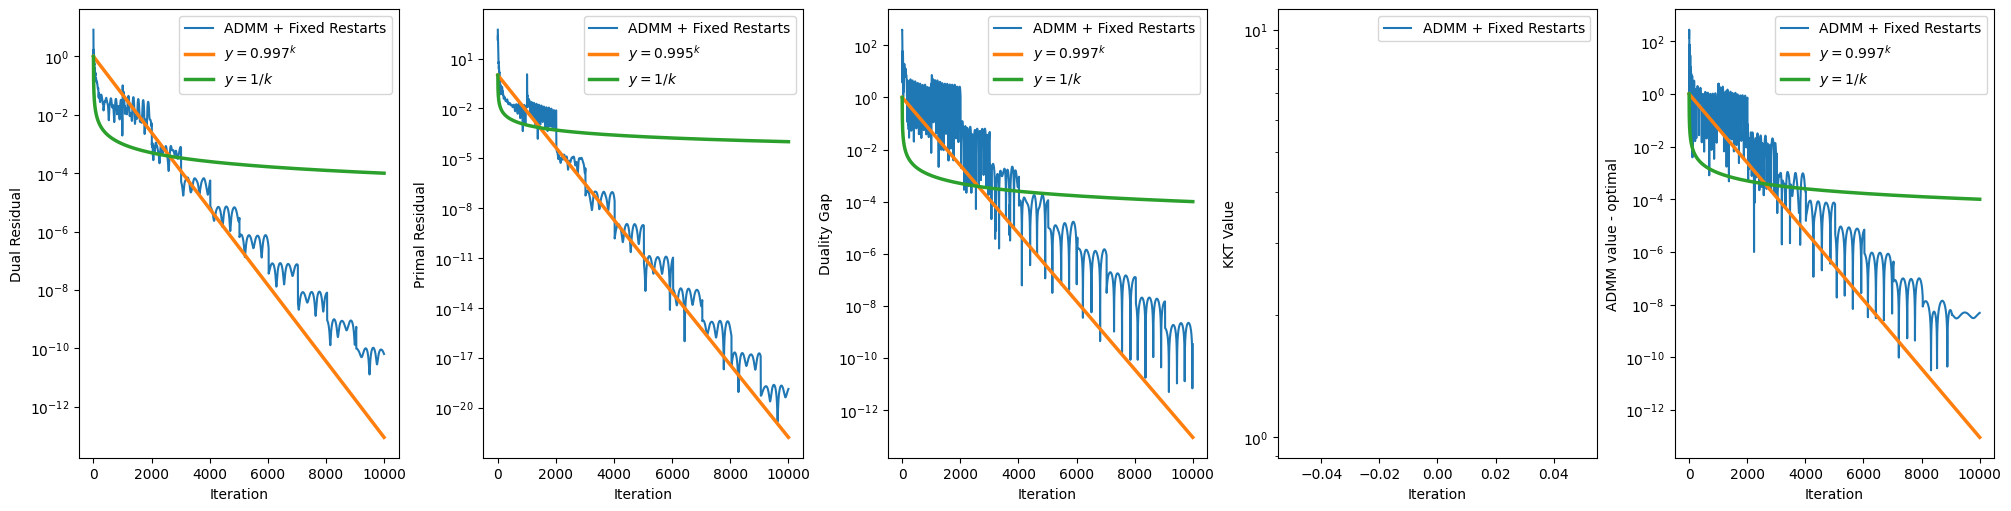

In [91]:
# NOTE
# ADMM + KKT Restarts
fig, ax = plt.subplots(1, 5, figsize=(20,5), constrained_layout=True)

ax[0].plot(dual_residual_rest_fixed, label='ADMM + Fixed Restarts')
ax[0].set_yscale('log')
ax[0].set_ylabel('Dual Residual')
ax[0].set_xlabel('Iteration')
ax[0].legend()

ax[1].plot(primal_residual_rest_fixed, label='ADMM + Fixed Restarts')
ax[1].set_yscale('log')
ax[1].set_ylabel('Primal Residual')
ax[1].set_xlabel('Iteration')
ax[1].legend()

ax[2].plot(duality_gap_res_fixed, label='ADMM + Fixed Restarts')
ax[2].set_yscale('log')
ax[2].set_ylabel('Duality Gap')
ax[2].set_xlabel('Iteration')
ax[2].legend()

ax[3].plot(KKT_valus_rest_fixed, label='ADMM + Fixed Restarts')
ax[3].set_yscale('log')
ax[3].set_ylabel('KKT Value')
ax[3].set_xlabel('Iteration')
ax[3].legend()

ax[4].plot(value_ADMM_restarts_fixed, label='ADMM + Fixed Restarts')
ax[4].set_yscale('log')
ax[4].set_ylabel('ADMM value - optimal')
ax[4].set_xlabel('Iteration')
ax[4].legend()


# Plot against a linear convergence
k_value = np.arange(0, 10000, 1)
# y_value = 0.6 ** k_value
y_value = (0.997) ** k_value

ax[0].plot(y_value, label=r"$y=0.997^k$", linewidth=2.5)
ax[0].legend()

y_value = (0.995) ** k_value

ax[1].plot(y_value, label=r"$y=0.995^k$", linewidth=2.5)
ax[1].legend()

y_value = (0.997) ** k_value
ax[2].plot(y_value, label=r"$y=0.997^k$", linewidth=2.5)
ax[2].legend()

# ax[3].plot(y_value, label=r"$y=0.995^k$", linewidth=2.5)
# ax[3].legend()

ax[4].plot(y_value, label=r"$y=0.997^k$", linewidth=2.5)
ax[4].legend()



# Plot against a sublinear convergence
k_value = np.arange(0, 10000, 1)
y_value = 1 / k_value

ax[0].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[0].legend()

ax[1].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[1].legend()

ax[2].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[2].legend()

# ax[3].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
# ax[3].legend()

ax[4].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[4].legend()


# ax[4].set_ylim(1e-15)
# ax[1].set_ylim(1e-30)
# ax[2].set_ylim(1e-15)
# ax[3].set_ylim(1e-15)

C:\Users\baice\AppData\Local\Temp\ipykernel_46196\12196998.py:96: RuntimeWarning: divide by zero encountered in divide
  y_value = 1 / k_value


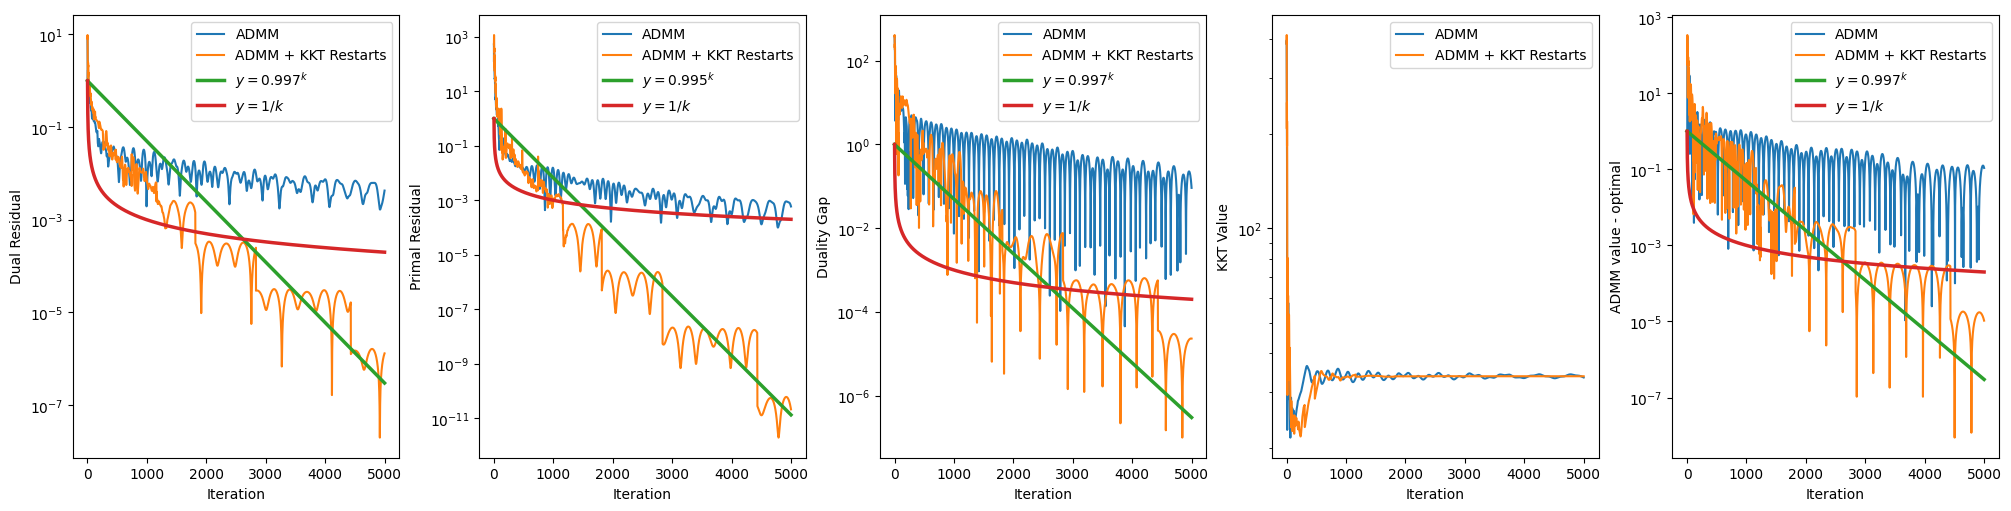

In [92]:
fig, ax = plt.subplots(1, 5, figsize=(20,5), constrained_layout=True)

# NOTE
# ADMM

ax[0].plot(dual_residual, label='ADMM')
ax[0].set_yscale('log')
ax[0].set_ylabel('Dual Residual')
ax[0].set_xlabel('Iteration')
ax[0].legend()

ax[1].plot(primal_residual, label='ADMM')
ax[1].set_yscale('log')
ax[1].set_ylabel('Primal Residual')
ax[1].set_xlabel('Iteration')
ax[1].legend()

ax[2].plot(duality_gap, label='ADMM')
ax[2].set_yscale('log')
ax[2].set_ylabel('Duality Gap')
ax[2].set_xlabel('Iteration')
ax[2].legend()

ax[3].plot(KKT_valus, label='ADMM')
ax[3].set_yscale('log')
ax[3].set_ylabel('KKT Value')
ax[3].set_xlabel('Iteration')
ax[3].legend()

ax[4].plot(value_ADMM, label='ADMM')
ax[4].set_yscale('log')
ax[4].set_ylabel('ADMM value - optimal')
ax[4].set_xlabel('Iteration')
ax[4].legend()

# NOTE
# ADMM + KKT Restarts
ax[0].plot(dual_residual_rest, label='ADMM + KKT Restarts')
ax[0].set_yscale('log')
ax[0].set_ylabel('Dual Residual')
ax[0].set_xlabel('Iteration')
ax[0].legend()

ax[1].plot(primal_residual_rest, label='ADMM + KKT Restarts')
ax[1].set_yscale('log')
ax[1].set_ylabel('Primal Residual')
ax[1].set_xlabel('Iteration')
ax[1].legend()

ax[2].plot(duality_gap_res, label='ADMM + KKT Restarts')
ax[2].set_yscale('log')
ax[2].set_ylabel('Duality Gap')
ax[2].set_xlabel('Iteration')
ax[2].legend()

ax[3].plot(KKT_valus_rest, label='ADMM + KKT Restarts')
ax[3].set_yscale('log')
ax[3].set_ylabel('KKT Value')
ax[3].set_xlabel('Iteration')
ax[3].legend()

ax[4].plot(value_ADMM_restarts, label='ADMM + KKT Restarts')
ax[4].set_yscale('log')
ax[4].set_ylabel('ADMM value - optimal')
ax[4].set_xlabel('Iteration')
ax[4].legend()


# Plot against a linear convergence
k_value = np.arange(0, 5000, 1)
# y_value = 0.6 ** k_value
y_value = (0.997) ** k_value

ax[0].plot(y_value, label=r"$y=0.997^k$", linewidth=2.5)
ax[0].legend()

y_value = (0.995) ** k_value

ax[1].plot(y_value, label=r"$y=0.995^k$", linewidth=2.5)
ax[1].legend()

y_value = (0.997) ** k_value
ax[2].plot(y_value, label=r"$y=0.997^k$", linewidth=2.5)
ax[2].legend()

# ax[3].plot(y_value, label=r"$y=0.995^k$", linewidth=2.5)
# ax[3].legend()

ax[4].plot(y_value, label=r"$y=0.997^k$", linewidth=2.5)
ax[4].legend()



# Plot against a sublinear convergence
k_value = np.arange(0, 5000, 1)
y_value = 1 / k_value

ax[0].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[0].legend()

ax[1].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[1].legend()

ax[2].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[2].legend()

# ax[3].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
# ax[3].legend()

ax[4].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[4].legend()


# ax[4].set_ylim(1e-15)
# ax[1].set_ylim(1e-30)
# ax[2].set_ylim(1e-15)
# ax[3].set_ylim(1e-15)

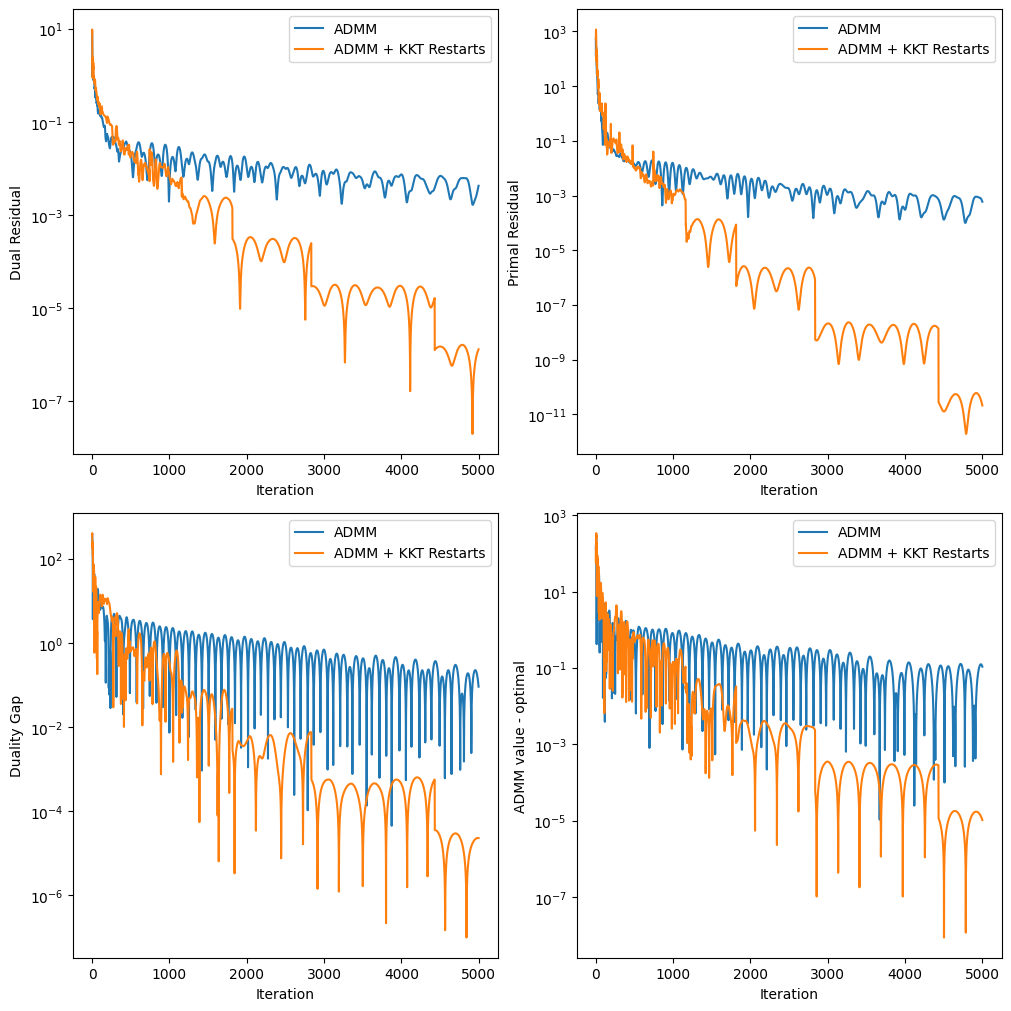

In [93]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), constrained_layout=True)

# NOTE
# ADMM

ax[0,0].plot(dual_residual, label='ADMM')
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Dual Residual')
ax[0,0].set_xlabel('Iteration')
ax[0,0].legend()

ax[0,1].plot(primal_residual, label='ADMM')
ax[0,1].set_yscale('log')
ax[0,1].set_ylabel('Primal Residual')
ax[0,1].set_xlabel('Iteration')
ax[0,1].legend()

ax[1,0].plot(duality_gap, label='ADMM')
ax[1,0].set_yscale('log')
ax[1,0].set_ylabel('Duality Gap')
ax[1,0].set_xlabel('Iteration')
ax[1,0].legend()

ax[1,1].plot(value_ADMM, label='ADMM')
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('ADMM value - optimal')
ax[1,1].set_xlabel('Iteration')
ax[1,1].legend()

# NOTE
# ADMM + KKT Restarts
ax[0,0].plot(dual_residual_rest, label='ADMM + KKT Restarts')
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Dual Residual')
ax[0,0].set_xlabel('Iteration')
ax[0,0].legend()

ax[0,1].plot(primal_residual_rest, label='ADMM + KKT Restarts')
ax[0,1].set_yscale('log')
ax[0,1].set_ylabel('Primal Residual')
ax[0,1].set_xlabel('Iteration')
ax[0,1].legend()

ax[1,0].plot(duality_gap_res, label='ADMM + KKT Restarts')
ax[1,0].set_yscale('log')
ax[1,0].set_ylabel('Duality Gap')
ax[1,0].set_xlabel('Iteration')
ax[1,0].legend()

ax[1,1].plot(value_ADMM_restarts, label='ADMM + KKT Restarts')
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('ADMM value - optimal')
ax[1,1].set_xlabel('Iteration')
ax[1,1].legend()

# plt.savefig('ADMM LP.pdf')